In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [2]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,                                   # paste your telegram_id
    'model_name': 'JAN_LSTM'
}

tg_callback = TelegramCallback(config)

In [3]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [4]:
train_ids = [1,2,3, 7, 8, 9, 10,12,13,14,15,16,17]
test_ids = [4,5,6,11]

In [5]:
dfAll = pd.read_pickle("PklData/df_lstm_norm30.pkl")

In [6]:
dfAll.TaskID[dfAll.TaskID>=17] = dfAll.TaskID - 17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
#dfNew = dfAll[dfAll.TaskID.isin([0, 2, 4,6,8,9,10,11,13,15])].copy()
#y = pd.Series([0, 2, 4,6,8,9,10,11,13,15], index=[0,1,2,3,4,5,6,7,8,9])
#dfNew.TaskID = dfNew.TaskID.replace([0, 2, 4,6,8,9,10,11,13,15], [0,1,2,3,4,5,6,7,8,9])
#dfAll = dfNew

In [8]:
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids)]

df_train2 = df_train[['Blobs', 'TaskID']].copy()
df_test2 = df_test[['Blobs', 'TaskID']].copy()

In [9]:
x_train = np.concatenate(df_train2.Blobs.values).reshape(-1,30,27,15,1)
x_test = np.concatenate(df_test2.Blobs.values).reshape(-1,30,27,15,1)

y_train = df_train2.TaskID.values
y_test = df_test2.TaskID.values



In [10]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(dfAll.TaskID.unique())
y_train_one_hot = utils.to_categorical(df_train2.TaskID, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.TaskID, num_classes)

In [11]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.3

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [12]:
batch_size = 60
epochs = 100
timesteps = 30
data_dim = (27,15)

tf.get_default_graph()
model = Sequential()

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', 
            padding='same', kernel_regularizer=regularizers.l2(0.01)), input_shape=(30, 27,15,1)))
model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))))
#model.add(TimeDistributed(BatchNormalization(axis=-1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last')))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))))
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))))
#model.add(TimeDistributed(BatchNormalization(axis=-1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last')))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(512, return_sequences=True, input_shape=(timesteps, data_dim), kernel_regularizer=regularizers.l2(0.01)))
model.add(TimeDistributed(Dropout(0.50)))
model.add(LSTM(256, kernel_regularizer=regularizers.l2(0.01)))


model.add(Dense(num_classes, activation='softmax'))

#optimizer = optimizers.Adagrad()
optimizer = optimizers.Adam(lr = 0.0001, decay=1e-6)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Broadcast progress to the tensorboard.
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_LSTM_Jan_" + readable_timestamp

config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

model.summary()

readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_LSTM_Jan_" + readable_timestamp
print("KnuckleFinger_LSTM_Jan_" + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_LSTM_Jan_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)

history = model.fit(x_train, y_train_one_hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test_one_hot),
                        callbacks=[storer,logger,tg_callback, learning_rate_reduction])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 27, 15, 64)    640       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 27, 15, 64)    36928     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 14, 8, 64)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 14, 8, 64)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 14, 8, 32)     18464     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 14, 8, 32)     9248      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 7, 4, 32)      0         
__________

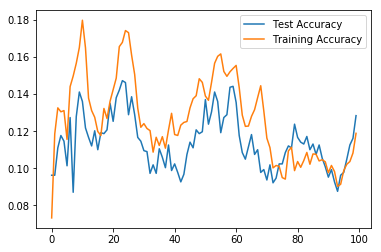

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    model.save('lstm_23_01_19.h5')